<a href="https://colab.research.google.com/github/aaronyu888/deceptive-amazon-review-detection/blob/main/SVM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
# import statements
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from scipy.sparse import csr_matrix
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [19]:
# read csv produced from Preprocess.ipynb
review_df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Deceptive Review Detection/processed.csv')
review_df.dropna(inplace=True)
# review_df.head()

In [20]:
# generate a vocabulary for text_transformer
Tfidf_vect = TfidfVectorizer()
Tfidf_vect.fit(review_df['text_final'].values.astype(str))
# Tfidf_vect.vocabulary_

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [21]:
# TfidfVectorizer is only for text data
text_features = 'text_final'
text_transformer = Pipeline(steps=[('vectorizer', TfidfVectorizer(vocabulary=Tfidf_vect.vocabulary_))])

# one hot encoder is preferable for non-target categorical features
categorical_features = ['RATING', 'VERIFIED_PURCHASE', 'PRODUCT_CATEGORY']
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('cat', categorical_transformer, categorical_features), ('text', text_transformer, text_features)])
clf =  Pipeline(steps=[('preprocessor', preprocessor), ('model', SVC(kernel='linear', C=1, random_state=500))])

le = LabelEncoder()
X_train, X_test, y_train, y_test = model_selection.train_test_split(review_df[['RATING', 'VERIFIED_PURCHASE', 'PRODUCT_CATEGORY', 'text_final']], le.fit_transform(review_df['LABEL'].values.astype(str)), test_size = 0.3)

In [22]:
svm = clf.fit(X_train, y_train)
print(svm.score(X_test, y_test))

0.7947619047619048


In [23]:
# extracts feature names from pipeline
text_feature_names = clf.get_params()['preprocessor'].named_transformers_['text'].named_steps['vectorizer'].get_feature_names()
category_feature_names = clf.get_params()['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names()

In [24]:
# extracts corresponding coefficients
coefs = clf.get_params()['model'].coef_

In [25]:
zipped = zip(category_feature_names, coefs.toarray().flatten()[:len(category_feature_names)])
category_feature_df = pd.DataFrame(zipped, columns=['feature', 'value'])
category_feature_df['abs_value'] = category_feature_df['value'].apply(lambda x: abs(x))
category_feature_df['colors'] = category_feature_df['value'].apply(lambda x: 'green' if x > 0 else 'red')
category_feature_df = category_feature_df.sort_values('abs_value', ascending=False)
category_feature_df.head()

,feature,value,abs_value,colors
6,x1_Y,0.987634,0.987634,green
5,x1_N,-0.987634,0.987634,red
11,x2_Books,0.348629,0.348629,green
33,x2_Video DVD,0.252280,0.252280,green
7,x2_Apparel,-0.237989,0.237989,red


Text(0.5, 0, 'Coefficients')

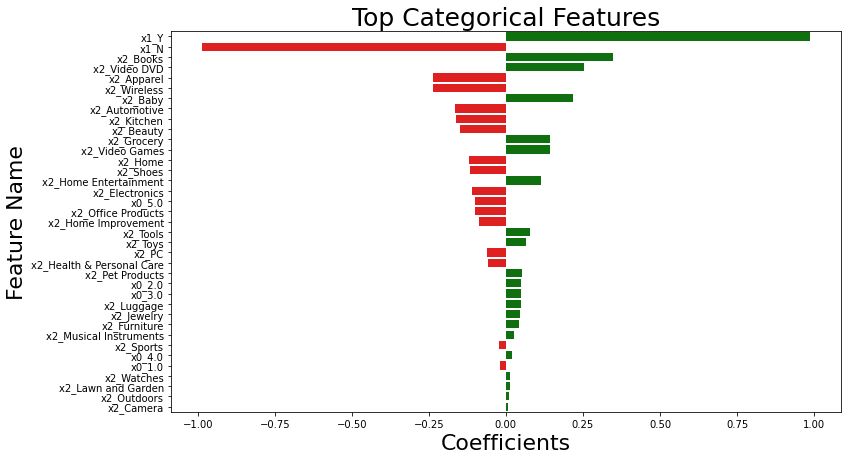

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="value",
            y="feature",
            data=category_feature_df.head(50),
           palette=category_feature_df.head(50)["colors"], orient='h')
ax.set_title("Top Categorical Features", fontsize=25)
ax.set_ylabel("Feature Name", fontsize=22)
ax.set_xlabel("Coefficients", fontsize=22)

In [27]:
zipped = zip(text_feature_names, coefs.toarray().flatten()[len(category_feature_names):])
text_feature_df = pd.DataFrame(zipped, columns=['word', 'value'])
text_feature_df['abs_value'] = text_feature_df['value'].apply(lambda x: abs(x))
text_feature_df['colors'] = text_feature_df['value'].apply(lambda x: 'green' if x > 0 else 'red')
text_feature_df = text_feature_df.sort_values('abs_value', ascending=False)
text_feature_df.head()

,word,value,abs_value,colors
10695,http,-3.599494,3.599494,red
720,amazing,-2.508164,2.508164,red
18142,really,-2.367168,2.367168,red
5251,curl,2.121776,2.121776,green
11606,invicta,1.875664,1.875664,green


Text(0.5, 0, 'Coefficients')

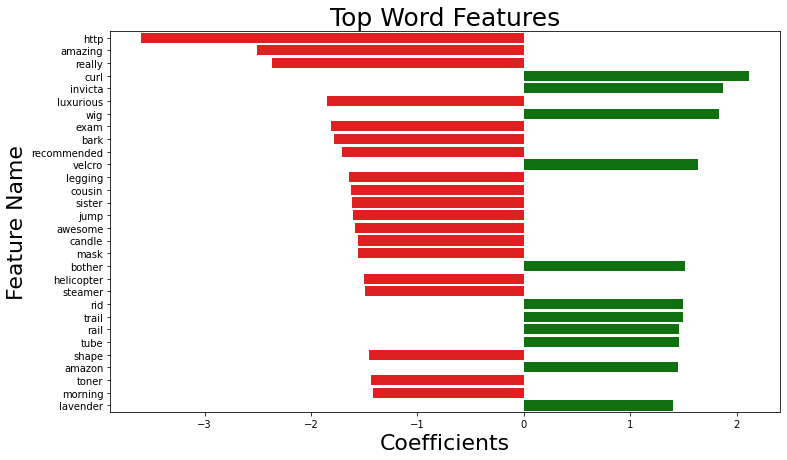

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="value",
            y="word",
            data=text_feature_df.head(30),
           palette=text_feature_df.head(30)["colors"], orient='h')
ax.set_title("Top Word Features", fontsize=25)
ax.set_ylabel("Feature Name", fontsize=22)
ax.set_xlabel("Coefficients", fontsize=22)